In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir

In [10]:
def CreateMasterThetaDF(dirName="."):
    """CreateMasterThetaDF(dirName) where dirName is the directory name of the .theta files,
       output pandas dataframe of all theta files header data and filenames"""
    assert isinstance(dirName, str), "The 'dirName' argument must be a string!"
    fileNames = [dirName+'/'+i for i in listdir(dirName) if i[-6:] == '.theta']
    
    if len(fileNames)==0:
        print("No '.theta' files found in directory '"+dirName+"'.")
        return
    
    D = {"file_name" : []}
    for index,name in enumerate(fileNames):
        f = open(name,'r')
        for i in range(2): colNames = f.readline().split()
        if index == 0:
            for colName in colNames:
                D[colName] = []
        D["file_name"].append(name)
        simParams = f.readline().split()
        for colIndex,colName in enumerate(colNames):
            D[colName].append(float(simParams[colIndex]))
        f.close()
    df = pd.DataFrame(D)
    return df

def CreateThetaDF(fileName):
    """CreateThetaDF(fileName) where fileName is the name of the .theta file,
       output pandas dataframe of .theta histogram data"""
    assert isinstance(fileName, str), "The 'fileName' argument must be a string!"
    try:
        f = open(fileName,'r')
    except:
        print("Failed to open file '" + fileName + "'.")
        return
    
    for i in range(4): colNames = f.readline().split()
    D = {}
    for colName in colNames:
        D[colName] = []
    for line in f:
        line = line.split()
        for colIndex, colName in enumerate(colNames):
            D[colName].append(float(line[colIndex]))
    f.close()
    df = pd.DataFrame(D)
    return df

In [25]:
def CreatePlotsMaster(master_df):
    """TODO"""
    assert isinstance(master_df,pd.DataFrame), "master_df must be pandas DataFrame type"
    
    for i in master_df.index:
        CreateThetaPlot(master_df.iloc[i])
    
def CreateThetaPlot(theta_series):
    """CreateThetaPlot(dataframe) where dataframe is a pandas Series that
    contains the header data for a .theta file (a slice of a theta master dataframe)"""
    
    assert isinstance(theta_series,pd.Series),"theta_series must be pandas Series type"
    if theta_series["n_dim"]!=3:
        print("Dimensionality must be 3D.")
        return
    df=CreateThetaDF(theta_series["file_name"])
    factor = 0.5*len(df.index)*theta_series["n_spec"]/theta_series["n_filaments"]/theta_series["n_steps"]
    for k in range(1,len(df.columns)):
        s = df.iloc[:,k]
        err = pd.Series(np.zeros(len(df.index)))
        for i,j in enumerate(s):
            err[i] = np.sqrt(j)*factor
        s *= factor
        df[df.columns[k]+'_err']=err

    plotEvery=100
    plt.figure()
    plt.errorbar(df.iloc[:,0][::plotEvery],df.iloc[:,1][::plotEvery],yerr=df['theta_12_err'][::plotEvery])
    la = theta_series["persistence_length"]/theta_series["bond_length"]
    if la == 0:
        const = 2.0
    else:
        const = 2.0*np.sinh(la)/la
    y = lambda x : np.exp(la*x)/const
    x=np.linspace(-1.0,1.0,1000)
    plt.plot(x,y(x),'r-')
    if theta_series["persistence_length"] == 0:
        plt.ylim(0,1)
    plt.title('Lp = '+str(theta_series["persistence_length"])+", L = "+str(theta_series["length"])+", cL = "+str(theta_series["bond_length"]))
    plt.xlabel(r'cos($\theta$)')
    plt.ylabel(r'P(cos($\theta$))')
    plt.legend(["Simulation","Theory"],loc=2)
    #plt.yscale("Log")
    plt.show()
    plt.close()

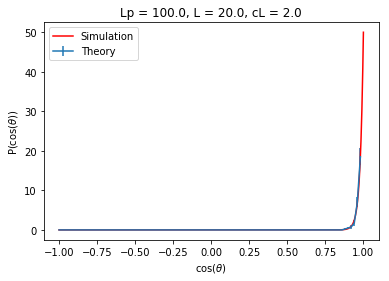

In [26]:
thetaMasterDF = CreateMasterThetaDF('../20190710_211712') # Replace '.' with directory name of .theta files
CreatePlotsMaster(thetaMasterDF)

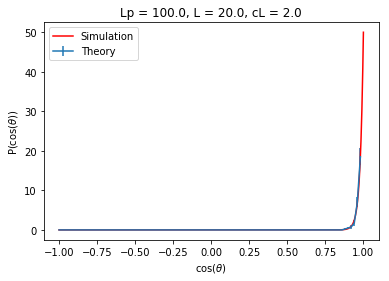

In [27]:
CreateThetaPlot(thetaMasterDF.iloc[0])

In [28]:
thetaMasterDF

,file_name,length,diameter,bond_length,persistence_length,driving,n_filaments,n_bonds,n_steps,n_spec,delta,n_dim,metric_forces
0,../20190710_211712/diffusion_test_filament.theta,20.0,1.0,2.0,100.0,0.0,20.0,10.0,100000.0,100.0,0.0001,3.0,1.0
